#  Disentangled Sequential Variational Autoencoder using Tensorflow Probability

## Introduction

> This notebook is in very early stages of development and is not ready for public consumption.
When it is complete...

### Definition

Here we develop and test a disentangled sequential variational autoencoder. Let's break that down.

An **autoencoder** first encodes an input into a low-dimensional latent representation (a.k.a. compress, bottleneck), and from there decodes (a.k.a. generates) an output that resembles the input.

As our input is a multidimensional timeseries or sequence, and we use sequence-based methods like recurrent LSTM, this is called a **sequential autoencoder**.

As the inputs to the decoder are not deterministic variables, but are prescribed to be random variables (typically gaussian), this is called **variational**.

Finally, the training is designed so that the model learns to encode a latent representation that is split into features that **disentangle** time-dependent features (dynamics) and static features (content / context). Note that disentangled auto-encoders are by necessity variational, so we could drop the implied "variational" from our title. Alternatively, the disentanglement is often parameterized by a $\beta$ , so this could also be called a $\beta$-VAE.

### Application

An autoencoder can be trained in a self-supervised manner. That is, we don't need to care about the data labels to train it. This is greate because labeling data is often the most difficult part about getting training data.

Once trained, there are several applications for such a model.

The decoder part of the model is generative: we can provide an initial condition and then generate a realistic signal. For brain signals, this might be a useful tool to understand the model. In other domains, this can be used to generate animations / audio / video with e.g. the same movements, but the characteristics of the object changes.

The encoder part of the model takes a real input and compresses it to a meaningful latent representation. We know it is meaningful because it is sufficient to generate the input. These latent feature vectors are much more tractable as inputs into a simple decoder. Thus, the autoencoder can first be trained using all unlabeled data, then the encoder part can be transferred as the top layers of a new classification model that is further trained on a smaller labeled data set.

### Resources

[Li and Mandt, ICML 2018](https://arxiv.org/pdf/1803.02991.pdf)

[TF Probability examples](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/disentangled_vae.py)

## Prepare Notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import sys


try:
    # See if we are running on google.colab
    from google.colab import files
    %tensorflow_version 2.x
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json

    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install git+https://github.com/SachsLab/indl.git
    !pip install -q kaggle
    IN_COLAB = True

except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.layers as tfkl
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
if IN_COLAB:
    plt.style.use('dark_background')
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 2,
    'lines.markersize': 5,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.figsize': (6.4, 6.4)
})

## Prepare Data

While I'm figuring this out, I'll use a contrived dataset. Let's assume that we have 4 different latent variables. Each latent variable evolves over time. The evolution over time is described by the combination of 3 functions: minimum-jerk velocity, sigmoid, and sinusoid. The mixing of the functions depends on the trial label, of which there are 5 distinct labels. The evolved latent variables are then mixed to yield 32 sensor-space signals, using a static mixing matrix.

In [48]:
N_LATENTS = 4
N_SENSORS = 32
FS = 64
DURATION = 2  # seconds
n_timesteps = int(DURATION * FS)
N_CONDITIONS = 5

np.random.seed(0)
mix_mat = np.random.randn(N_LATENTS, N_SENSORS)
func_mix = np.random.randn(N_CONDITIONS)

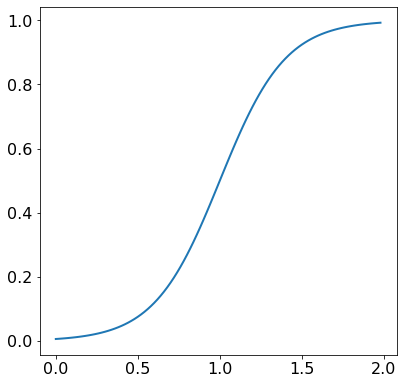

In [55]:
# TODO: Put in indl
def sigmoid(x, A=0, K=1, C=1, Q=1, B=1, v=1, x_offset=0.5):
    return A + (K - A) / ((C + Q * np.exp(-B*(x - x_offset)))**(1/v))

x = np.arange(100) / 50
y = sigmoid(x, B=5, x_offset=1.0)
plt.plot(x, y)

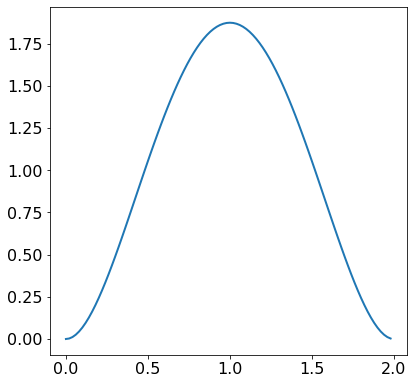

In [54]:
# https://storage.googleapis.com/wzukusers/user-31382847/documents/5a7253343814f4Iv6Hnt/minimumjerk.pdf
# TODO: Clean this up and provide docstrings for the parameters, then put it in indl.
def minimumJerk(t, duration, xi, xf, degree=1):
    
    t_d = t / duration

    if degree not in [1, 2]:
        # Default - no derivative
        # output = xi + (xf - xi) .* (10*(t_d.^3) - 15*(t_d.^4) + 6*(t_d.^5));
        k0 = xi
        x1 = 10 * t_d**3
        x2 = -15 * t_d**4
        x3 = 6 * t_d**5
    elif degree == 1:
        # Velocity
        k0 = 0
        x1 = 30 * t_d**2
        x2 = -60 * t_d**3
        x3 = 30 * t_d**4
    elif degree == 2:
        # Acceleration
        k0 = 0
        x1 = 60 * t_d
        x2 = -180 * t_d**2
        x3 = 120 * t_d**3

    return k0 + (xf - xi) * (x1 + x2 + x3)

y = minimumJerk(x, DURATION, 0.0, 1.0)
plt.plot(x, y)